In [9]:
# import necessary dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from resnet import *
import pickle
import datetime

In [2]:
# select GPU if available, else CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# define transformations on training set and testing set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # CIFAR-10 normalization, check: https://stackoverflow.com/questions/50710493/cifar-10-meaningless-normalization-values
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
# get CIFAR-10 dataset and prepare train and test loaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# classes of CIFAR-10, in order
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# build ResNet-18 model
net = ResNet18()
net = net.to(device)
# setup for data parallel operations
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# initialize loss function, optimizer and LR scheduler
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [8]:
# training function
# reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar
def train(epoch, net):
    '''
    this function trains network on training dataset
    '''
    # set network to training mode
    net.train()
    
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # move data to device - GPU or CPU, as available
        inputs, targets = inputs.to(device), targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # calculate training loss
        train_loss += loss.item()
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/len(trainloader)

In [10]:
# testing function
def test(epoch, net):
    '''
    this function evaluates network on testing dataset
    '''
    # set variable for global access
    global acc
    
    # set network to testing mode
    net.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100 * correct / total
    
    return test_loss/len(testloader)

In [11]:
# train and evaluate naive network
train_losses=[]
test_losses=[]
epochs=20

# get a sense of execution time
print(datetime.datetime.now())

# run through number of epochs
for epoch in range(0,epochs):
    train_losses.append(train(epoch, net))
    test_losses.append(test(epoch, net))
    scheduler.step()

print(datetime.datetime.now())

2022-05-16 11:58:20.795909
2022-05-16 12:07:46.564983


In [12]:
print(f"Accuracy of the naive network on test images: {acc} %")

Accuracy of the naive network on test images: 88.13 %


In [ ]:
torch.save(net, "resnet18_cifar10.pth")

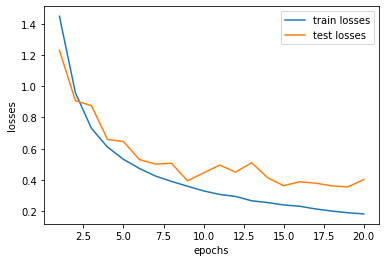

In [13]:
# plot train and test loss of naive network on CIFAR-10 images
epochs=20
plt.plot(np.arange(1,epochs+1),train_losses, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [14]:
# load data to visualize one sample from each class of the dataset
imgloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
dataiter = iter(imgloader)
org_images, org_labels = dataiter.next()

In [15]:
# transfer data to device
org_labels = org_labels.to(device)
org_images = org_images.to(device)
print(org_images.shape)

# inference
outputs = net(org_images)
output = outputs.to(device)
print(outputs.shape)

# the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs.data, 1)

torch.Size([100, 3, 32, 32])
torch.Size([100, 10])


In [16]:
# function to view images
# reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


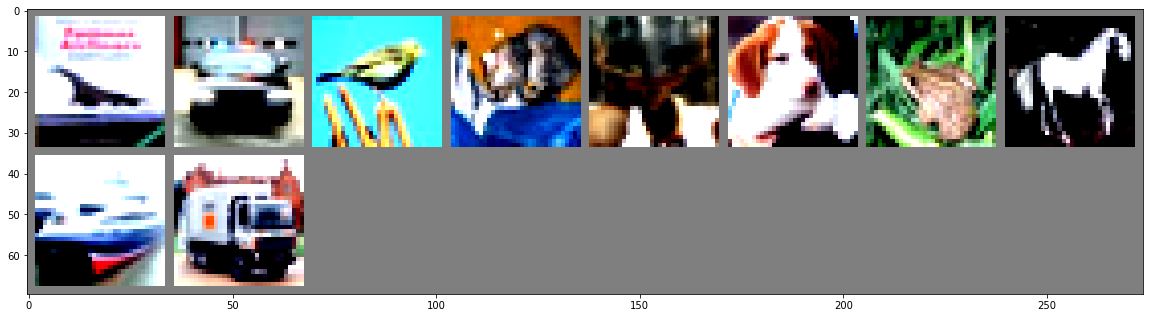

In [17]:
# visualizing one sample from each class of the dataset
samples = []
samples_labels = []
samples_pred = []

# select one image from each class
selected = [3, 66, 67, 0, 26, 16, 4, 13, 1, 11]

for i in selected:
    samples.append(org_images[i])
    samples_labels.append(org_labels[i])
    samples_pred.append(outputs[i])

samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)

imshow(torchvision.utils.make_grid(samples.cpu()))

### FGSM attack function - non-targeted
In the FGSM attack, we make adversarial examples using this equation:
$x_{adv}=x_{naive}+\epsilon * sign(\nabla_{x_{naive}}L(\theta, x, y))$

In [18]:
# define the FGSM attack function
def FGSM(net, x, y, eps):
        '''
        inputs:
            net: the network through which we pass the inputs
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            eps: perturbation limit

        outputs:
            x_adv: the adversarial example constructed from x
            h_adv: output of softmax when applying net on x_adv 
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''

        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        net.zero_grad()
        cost.backward()

        # perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _, y_adv = torch.max(h_adv.data, 1)
        
        return x_adv, h_adv, y_adv, pert


from left to right: perturbation, original image, adversarial example



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 0, adversary label: 8


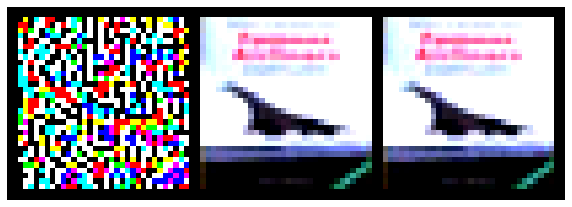

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 1, adversary label: 8


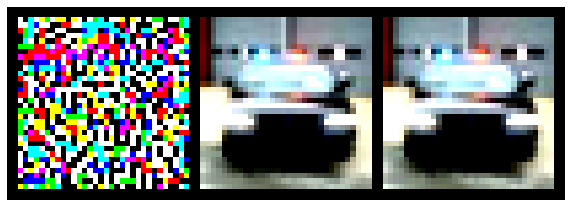

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 2, adversary label: 0


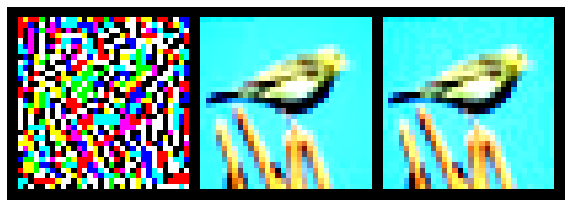

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 3, adversary label: 1


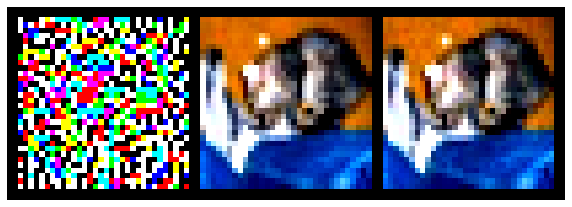

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 4, adversary label: 3


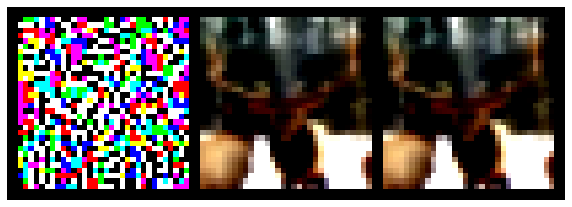

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 5, adversary label: 7


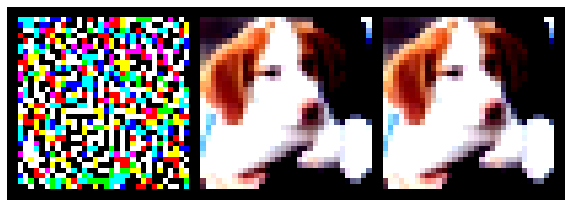

true label: 6, adversary label: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


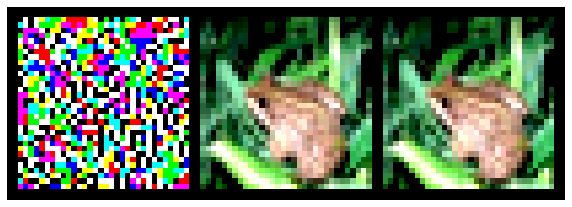

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 7, adversary label: 3


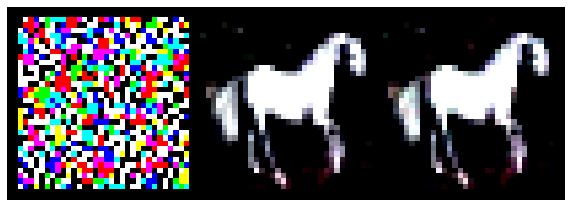

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 8, adversary label: 1


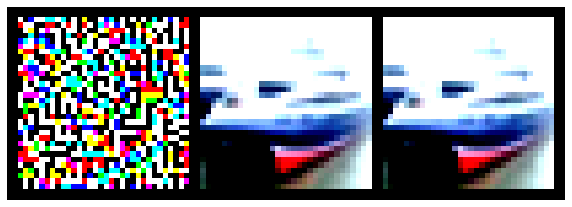

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 9, adversary label: 1


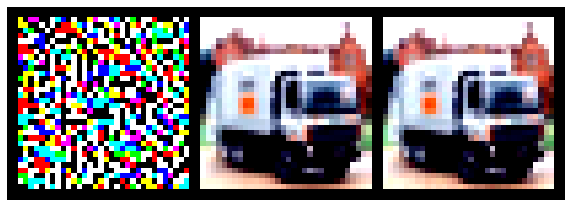

In [19]:
# Creating FGSM adversarial examples from selected samples with eps = 1/255
print()
print(f"from left to right: perturbation, original image, adversarial example")
print()

# loop through selected samples
for i in selected:
    eps=1.0/255
    
    while True:
        x_adv, h_adv, y_adv, pert = FGSM(net, org_images[i].unsqueeze_(0), org_labels[i].unsqueeze_(0), eps)
        
        # if labels match, update perturbation limit
        if y_adv.item() == org_labels[i].item():
            eps = eps + (1.0/255)
        else:
            break
    
    # display true and adversarial labels
    print(f"true label: {org_labels[i].item()}, adversary label: {y_adv.item()}")
    
    # show perturbation, original image and perturbed image
    triple=[]
    with torch.no_grad():
        triple.append((1/eps)*pert.detach().clone().squeeze_(0))
        triple.append(org_images[i])
        triple.append(x_adv.detach().clone().squeeze_(0))
        triple=torch.stack(triple)
        
        grid = torchvision.utils.make_grid(triple.cpu()/2+0.5)
        plt.figure(figsize=(10,10))
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()

#### Adversarial training with FGSM

In [20]:
net_adv = ResNet18()
net_adv = net_adv.to(device)
if device == 'cuda':
    net_adv = torch.nn.DataParallel(net_adv)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_adv = optim.SGD(net_adv.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=200)

In [21]:
# train_adv() trains a given neural network on adversarial examples generated from training data using
# the FGSM attack
def train_adv(epoch, net):
    net.train()
    
    train_loss = 0
    correct = 0
    total = 0
    eps = 8.0/255
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)
        cost = criterion(h_, targets)
        net.zero_grad()
        cost.backward()

        pert= eps*inputs_.grad.detach().sign()
        x_adv = inputs_ + pert

        optimizer_adv.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/len(trainloader)

In [22]:
train_losses_adv = []
test_losses_adv = []
epochs = 20

print(datetime.datetime.now())

for epoch in range(0, epochs):
    train_losses_adv.append(train_adv(epoch, net_adv))
    test_losses_adv.append(test(epoch, net_adv))
    scheduler_adv.step()
    
print(datetime.datetime.now())

2022-05-16 13:32:43.955574
2022-05-16 13:49:52.486063


In [ ]:
torch.save(net_adv, "fgsm.pth")

In [23]:
print(f"Accuracy of the adversarially-trained network on unperturbed test images: {acc} %")

Accuracy of the adversarially-trained network on unperturbed test images: 86.55 %


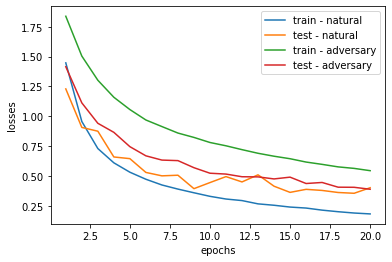

In [24]:
# Comparing naturally-trained and adversarially-trained models via plots
# train - natural: training loss of the naturally-trained model
# train - adversary: training loss of the adversarially-trained model
# test - natural:  loss of the naturally-trained model on original (unperturbed) test images
# test - adversary: loss of the adversarially-trained model on original (unperturbed) test images
plt.plot(np.arange(1,epochs+1),train_losses, label='train - natural')
plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary')
plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [25]:
# test_adv() constructs adversarial examples from test data (with FGSM using net) and evaluates net_adv on them
def test_adv(net, net_adv, eps):
    accuracy=0
    
    net.train()
    net_adv.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM(net, inputs, targets, eps)
            
        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [26]:
# check accuracy of adversarially-trained model on FGSM-perturbed images

print(datetime.datetime.now())

for eps in [4.0/255, 8.0/255, 12.0/255]:
    accuracy = test_adv(net, net_adv, eps)
    print(f"epsilon: {eps}, accuracy: {accuracy}")
    
print(datetime.datetime.now())

2022-05-16 13:55:34.150818
epsilon: 0.01568627450980392, accuracy: 85.79
epsilon: 0.03137254901960784, accuracy: 85.06
epsilon: 0.047058823529411764, accuracy: 84.24
2022-05-16 13:55:59.788512


#### FGSM attack function - Targeted
In targeted attacks, we want the model to misclassify its input to the given target class. Therefore, instead of just maximizing the loss of the true label, we maximize the loss of the true label and minimize the loss for the alternative label.

In [27]:
def FGSM_targeted(net, x, y, t, eps):
        '''
        inputs:
            net: the neural network through which we pass the input
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            t: target label
            eps: perturbation limit

        outputs:
            x_adv : the adversarial example constructed from x
            h_adv: output of softmax when applying net on x_adv 
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''
        
        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion = torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y) - criterion(h_, t)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert = eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _, y_adv = torch.max(h_adv.data, 1)
        
        return x_adv, h_adv, y_adv, pert  

#### A study
First, for each example, take as the target class the one having the highest probability in the probability output vector (if it is the same as the true label, choose the class with the second-highest probability) and second, take as the target class the one having the lowest probability in the probability output vector (again, if it is the same as the true label, choose the class with second-lowest probability) and generate adversarial examples using a targeted attack. Compare the accuracy of the adversarially-trained model and naturally-trained model on these examples.

In [28]:
def test_adv_targ(net, model, eps, mode='largest_prob'):
    acc = 0
    
    net.train()
    model.eval()
    
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        if mode=='largest_prob':
            out = net(inputs)
            _, largest = torch.kthvalue(out,10,1)
            _, second_largest = torch.kthvalue(out,9,1)
            condition = largest - targets
            target_adv = torch.where(condition==0, second_largest, largest)
        else:
            out = net(inputs)
            _, smallest = torch.kthvalue(out,1,1)
            _, second_smallest = torch.kthvalue(out,2,1)
            condition = smallest - targets
            target_adv = torch.where(condition==0, second_smallest, smallest)

        x_adv, h_adv, y_adv, pert = FGSM_targeted(net,inputs,targets,target_adv,eps)

        with torch.no_grad():
                outputs = model(x_adv)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    
    acc = 100 * correct / total
    
    return acc

In [29]:
# class with the *largest* probability (other than true class as the target class) for FGSM-targeted attack
eps = 8.0/255
acc1 = test_adv_targ(net,net,eps)
acc2 = test_adv_targ(net,net_adv,eps)
print(f"Accuracy of naturally-trained model against FGSM-targeted attack: {acc1} %")
print(f"Accuracy of adversarially-trained model against FGSM-targeted attack: {acc2} %")

Accuracy of naturally-trained model against FGSM-targeted attack: 30.4 %
Accuracy of adversarially-trained model against FGSM-targeted attack: 84.79 %


In [30]:
# class with the *lowest* probability (other than true class as the target class) for FGSM-targeted attack
eps = 8.0/255
acc1 = test_adv_targ(net,net,eps, mode='smallest_prob')
acc2 = test_adv_targ(net,net_adv,eps, mode='smallest_prob')
print(f"Accuracy of naturally-trained model against FGSM-targeted attack: {acc1} %")
print(f"Accuracy of adversarially-trained model against FGSM-targeted attack: {acc2} %")

Accuracy of naturally-trained model against FGSM-targeted attack: 48.51 %
Accuracy of adversarially-trained model against FGSM-targeted attack: 85.03 %
